In [4]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import albumentations as A
import albumentations.pytorch
import cv2
import sys
import random
import csv
import matplotlib.pyplot as plt
sys.path.append('../')
sys.path.append('../../data/')

from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import Sampler
import torch.optim as optim
from sklearn.model_selection import train_test_split

from dataset import LbpDataset, train_transforms, val_transforms, test_transforms, get_indices, get_hard_label, collate_fn
from loss import LBPloss
from visualize import visualize

from tqdm import tqdm
# from resnet import resnet18, resnet12
from model import Darknet

In [5]:
import gc
torch.cuda.empty_cache()
gc.collect()

44

In [6]:
df = pd.read_csv('../../data/df.csv')
print(df.shape)

(6736, 11)


In [7]:
print(df.label.value_counts())

AS                           1947
ASC-US                       1931
ASC-US with HPV infection     724
LSIL                          439
Candida                       402
C                             328
AH                            200
LS                            161
HS                            154
HSIL with HPV infection       137
LSIL with HPV infection        90
ASC-H                          75
HSIL                           70
Benign atypia                  46
Carcinoma                      18
H                               5
판독불가                            4
Negative                        3
ASCUS-SIL                       2
Name: label, dtype: int64


In [8]:
df['label_id'] = df.label.apply(lambda x : 1.0 if ('ASC-US' in str(x) ) or ('AS' == str(x)) else 0.)
df = df[df['label_id'] == 1.]
df.shape

(4602, 12)

<AxesSubplot:>

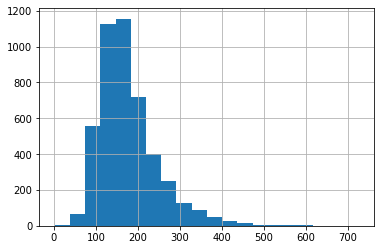

In [9]:
df.w.hist(bins=20)

In [10]:
df_data = df.groupby('file_name')
def get_data(img_id):
    if img_id not in df_data.groups:
        return dict(image_id=img_id, boxes=list())
    data  = df_data.get_group(img_id)
    boxes = data[['xmin', 'ymin', 'w', 'h', 'label_id']].values
    return dict(image_id = img_id, boxes = boxes)

In [11]:
df_list = df.file_name.unique()
train_list, test_list = train_test_split(df_list, test_size=0.2, random_state=42)
print('total {} train {} test {}'.format(len(df_list), len(train_list), len(test_list)))

train_list = [get_data(img_id) for img_id in train_list]
test_list = [get_data(img_id) for img_id in test_list]

print(len(train_list))
print(len(test_list))
train_list[0]

total 3970 train 3176 test 794
3176
794


{'image_id': 'patch_images/2021.01.14/LBC423-20210111(1)/LBC423-20210111(1)_1718.png',
 'boxes': array([[896., 155., 383., 355.,   1.]])}

In [12]:
# path = '/home/Dataset/scl/patch_images/2021.01.06/LBC24-20210102(1)/'
# file_list = ['patch_images/2021.01.06/LBC24-20210102(1)/' + d for d in os.listdir(path)]
# file_list[:2]

In [13]:
BATCH_SIZE = 2
STRIDE = 32
KERNEL_SIZE = 128
train_dataset = LbpDataset(
    train_list,
    transform=train_transforms,
    stride=STRIDE,
    kernel_size=KERNEL_SIZE
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=8,
#     pin_memory=config.PIN_MEMORY,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_fn
)

test_dataset = LbpDataset(
    test_list,
    transform=val_transforms,
    stride=STRIDE,
    kernel_size=KERNEL_SIZE    
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
#     pin_memory=config.PIN_MEMORY,
    shuffle=True,
    drop_last=False,
    collate_fn=collate_fn
)

In [14]:
images, cell_iou, targets, path, boxes = next(iter(train_loader))
# images = list(image for image in images)
images = np.stack(images)
cell_iou = torch.stack(cell_iou)
targets = torch.stack(targets)
iou, targets, multi_cell = get_hard_label(cell_iou, targets)
print(targets.shape)

torch.Size([2, 4096, 5])


In [15]:
print(targets[targets[:,:,0] == 1.][0][1].dtype)
targets[targets[:,:,0] == 1.].dtype

torch.float32


torch.float32

In [16]:
((cell_iou >= 0.5) & (cell_iou <= 1.0) ).sum()
((cell_iou > 0.) ).sum()
print((multi_cell == 1.).sum())
print((targets == 1.).sum())
print((multi_cell == 0.).sum())
print((cell_iou == 1.).sum())

tensor(2)
tensor(3)
tensor(186)
tensor(187)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


k_size 128 stride 32 grid size 64
(2048, 2048, 3)


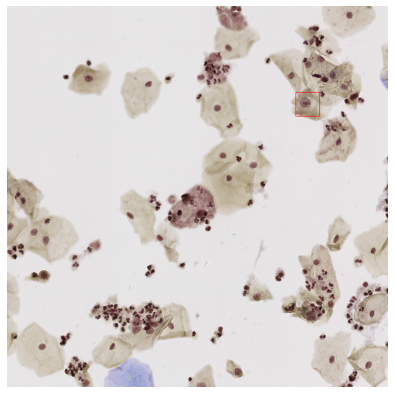

In [17]:
IMAGE_NUM = 1
STRIDE = 32
KERNEL_SIZE = STRIDE * 4
kernel_size = KERNEL_SIZE
stride = STRIDE
# grid_size = 1 + int((images[IMAGE_NUM].shape[1]- kernel_size) / stride )
grid_size = 64
print('k_size {} stride {} grid size {}'.format(kernel_size, stride, grid_size))
# row, col = torch.where((cell_iou[IMAGE_NUM].view(grid_size,grid_size) > 0.0) & \
#                        (cell_iou[IMAGE_NUM].view(grid_size,grid_size) <= 0.3))
row, col = torch.where((multi_cell[IMAGE_NUM].view(grid_size,grid_size) == 1.))
bboxes = []

for x, y in zip(col, row) :
#     print(int(x), int(y))
    xmin = int(x) * stride - (kernel_size-stride)/2
    xmax = xmin + kernel_size
    ymin = int(y) * stride - (kernel_size-stride)/2
    ymax = ymin + kernel_size
    bboxes.append([xmin, ymin, xmax, ymax])
# print(len(bboxes))

# visualize(images[IMAGE_NUM].permute(2,1,0).cpu().detach().numpy(), bboxes)
visualize(images[IMAGE_NUM], bboxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


k_size 128 stride 32 grid size 64
[[1552.0, 464.0, 1680.0, 592.0], [1504.440142638818, 444.24701608718215, 1744.3993886907795, 637.6751427088739]]
(2048, 2048, 3)


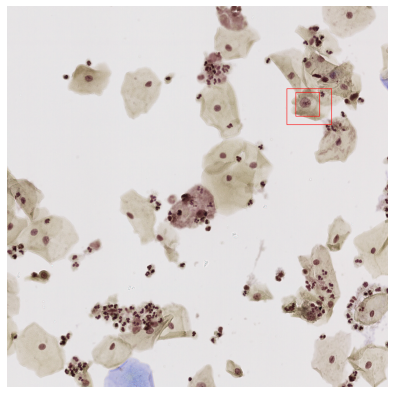

In [18]:
IMAGE_NUM = 1
STRIDE = 32
KERNEL_SIZE = STRIDE * 4
kernel_size = KERNEL_SIZE
stride = STRIDE
# grid_size = 1 + int((images[IMAGE_NUM].shape[1]- kernel_size) / stride )
grid_size = 64
targets = targets[:,:,0].unsqueeze(dim=-1)
print('k_size {} stride {} grid size {}'.format(kernel_size, stride, grid_size))
row, col = torch.where(targets.view(BATCH_SIZE,grid_size,grid_size)[IMAGE_NUM] == 1.)
bboxes = []
org_boxes = np.array(boxes[IMAGE_NUM])

kernel_size = KERNEL_SIZE
stride = STRIDE
for x, y in zip(col, row) :
    xmin = int(x) * stride - (kernel_size-stride)/2
    xmax = xmin + kernel_size
    ymin = int(y) * stride - (kernel_size-stride)/2
    ymax = ymin + kernel_size
    bboxes.append([xmin, ymin, xmax, ymax])
    
for box in boxes[IMAGE_NUM] :
    xmin, ymin, w, h, _ = box
    bboxes.append([xmin, ymin, xmin+w, ymin+h])
print((bboxes))
visualize(images[IMAGE_NUM], bboxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2048, 2048, 3)


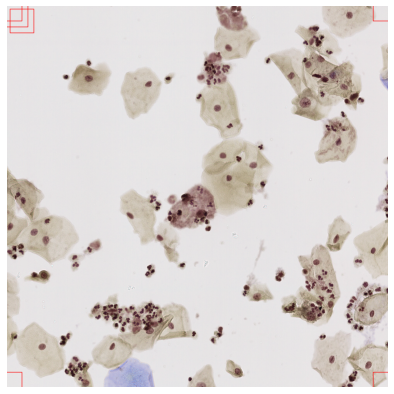

In [19]:
bboxes = []
for x, y in zip([0, 63, 0, 63, 1,2], [0,63, 63, 0, 1,2]) :
    xmin = int(x) * stride - (kernel_size-stride)/2
    xmax = xmin + kernel_size
    ymin = int(y) * stride - (kernel_size-stride)/2
    ymax = ymin + kernel_size
    bboxes.append([xmin, ymin, xmax, ymax])
visualize(images[IMAGE_NUM], bboxes)    

<class 'numpy.ndarray'>
[[332. 523. 230. 182.   1.]]
(2048, 2048, 3)


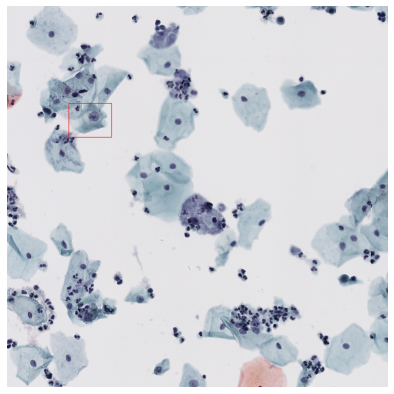

In [20]:
img_path = path[IMAGE_NUM]
abs_path = '/home/Dataset/scl/'

train_image = cv2.imread(abs_path + img_path)
print(type(train_image))
train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
boxes = get_data(img_path)['boxes']
print(boxes)
boxes[:,2] = boxes[:,0] + boxes[:,2]
boxes[:,3] = boxes[:,1] + boxes[:,3]

visualize(train_image, boxes[:,:4])

In [21]:
device = torch.device('cuda')
model = Darknet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4 )
loss_fn = LBPloss(device).to(device)
scaler = torch.cuda.amp.GradScaler()

In [22]:
saved_model = '../trained_models/darknet/size1/'
if os.path.isdir(saved_model) == False :
    print('saved_dir is made')
    os.makedirs(saved_model)    


In [20]:
epochs = 60
init_loss = 2.

# model.load_state_dict(torch.load(saved_model))
for epoch in (range(epochs)) :
    batch_losses = []
    reg_losses = []
    ab_losses = []
    multi_losses = []
    loop = tqdm(train_loader, leave=True)
    model.train()
    for images, iou, targets, path, box in loop :
        images = torch.from_numpy(np.stack(images))
        iou = torch.stack(iou)
        targets = torch.stack(targets)        
        batch_size, grid_len, _ = iou.shape
        images = images.permute(0,3,1,2).to(device)

#         indices, iou, targets = get_indices(iou, targets)
        iou, targets, multi_cell = get_hard_label(iou, targets)
        labels = torch.cat([iou, targets, multi_cell], dim=-1)
        labels = labels.to(device)
        
        cell_out, ab_out, multi_out, point = model(images, indices=None)
        cell_out = cell_out.permute(0,2,3,1).view(batch_size, grid_len, -1)
        ab_out = ab_out.permute(0,2,3,1).view(batch_size, grid_len, -1)
        multi_out = multi_out.permute(0,2,3,1).view(batch_size, grid_len, -1)
        point = point.permute(0,2,3,1).view(batch_size, grid_len, -1)
        loss, cell_loss, ab_loss, multi_loss, reg_loss = loss_fn(cell_out, ab_out, multi_out, point, labels)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0/(epoch/3+1))
        optimizer.step()
        
        batch_losses.append(loss.item())
        ab_losses.append(ab_loss.item())
        multi_losses.append(multi_loss.item())
        reg_losses.append(reg_loss.item())
        mean_loss = sum(batch_losses) / len(batch_losses)
        mab_losses = sum(ab_losses) / len(ab_losses)
        mmulti_losses = sum(multi_losses) / len(multi_losses)
        mreg_losses = sum(reg_losses) / len(reg_losses)
        
        loop.set_postfix(total_loss=mean_loss, cell_loss=cell_loss.item(), 
                         multi_loss = mmulti_losses, ab_loss=mab_losses, reg_loss=mreg_losses) 

    if mean_loss < init_loss :
        init_loss = mean_loss
        state = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }        
        torch.save(state, saved_model + 'epoch_' + str(epoch) +'_model.pt')
        print('model is saved')


  0%|          | 1/1033 [00:02<43:47,  2.55s/it, ab_loss=0.126, cell_loss=0.13, multi_loss=0.124, reg_loss=0.0923, total_loss=1.41]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff1125f3d40>
Traceback (most recent call last):
  File "/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/multiproce

KeyboardInterrupt: 

In [21]:
saved_model = '../trained_models/darknet/size1/'
state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
#     'loss' : total_loss/(step+1),
#     'scheduler' : scheduler.state_dict()
}
torch.save(state, saved_model + 'epoch_' + str(epoch) +'_model.pt')
# saved_model = '../trained_models/model_v1.pt'

In [23]:
saved_model = '../trained_models/darknet/size1/'
device = torch.device('cuda')
model = Darknet().to(device)
state = torch.load(saved_model  + 'epoch_' + str(38) + '_model.pt')
model.load_state_dict(state['state_dict'])
# model.load_state_dict(state['optimizer'])
model.eval()

Darknet(
  (layers): ModuleList(
    (0): CNNBlock(
      (conv): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky): LeakyReLU(negative_slope=0.1)
    )
    (1): CNNBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky): LeakyReLU(negative_slope=0.1)
    )
    (2): ResidualBlock(
      (layers): ModuleList(
        (0): Sequential(
          (0): CNNBlock(
            (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (leaky): LeakyReLU(negative_slope=0.1)
          )
          (1): CNNBlock(
            (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

In [24]:
# BATCH_SIZE = 8
images, cell_iou, targets , path, box = next(iter(test_loader))
# images, cell_iou, targets , path = next(iter(test_loader))
images = torch.from_numpy(np.stack(images))
cell_iou = torch.stack(cell_iou)
targets = torch.stack(targets)
print(images.shape)
# print(cell_iou.shape)
batch_size, seq_len, _ = cell_iou.shape
images = images.permute(0,3,1,2).to(device)
iou, targets, multi_cell = get_hard_label(cell_iou, targets)
with torch.no_grad():
    cell_out, ab_out, multi_out, reg_out = model(images, indices=None)
print(cell_out.shape)    

torch.Size([2, 2048, 2048, 3])
torch.Size([2, 1, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


***************** tensor(0.8774)
1437
(2048, 2048, 3)


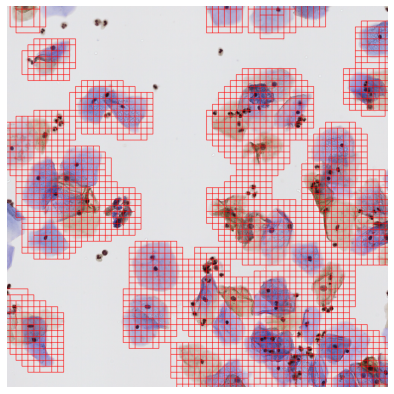

In [25]:
# image with prediction
IMAGE_NUM=0
outputs = cell_out
# maxi = torch.max(torch.sigmoid(outputs.permute(0,2,3,1)[IMAGE_NUM,:,:,0])).cpu()
maxi = torch.max((outputs.permute(0,2,3,1)[IMAGE_NUM,:,:,0])).cpu()
print('*****************', maxi)
row, col = ((outputs.permute(0,2,3,1)[IMAGE_NUM,:,:,0]) > 0.7).cpu().detach().nonzero(as_tuple=True)
bboxes = []

# for x, y in zip(row, col) :
for x, y in zip(col, row) :
    xmin = int(x) * stride - (kernel_size-stride)/2
    xmax = xmin + kernel_size
    ymin = int(y) * stride - (kernel_size-stride)/2
    ymax = ymin + kernel_size
    bboxes.append([xmin, ymin, xmax, ymax])
print(len(bboxes))
visualize(images[IMAGE_NUM].permute(1,2,0).cpu().detach().numpy(), bboxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


***************** tensor(0.6798)
9
(2048, 2048, 3)


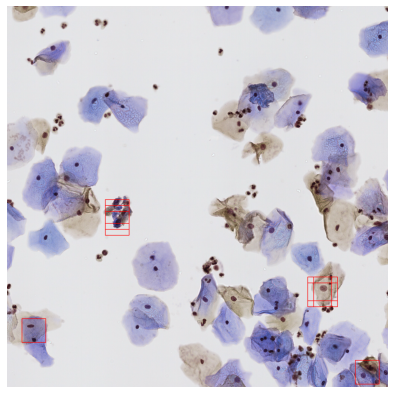

In [27]:
# image with prediction
# IMAGE_NUM=1
outputs = ab_out
# maxi = torch.max(torch.sigmoid(outputs.permute(0,2,3,1)[IMAGE_NUM,:,:,0])).cpu()
maxi = torch.max((outputs.permute(0,2,3,1)[IMAGE_NUM,:,:,0])).cpu()
print('*****************', maxi)
# row, col = ((outputs.permute(0,2,3,1)[IMAGE_NUM,:,:,0]) == maxi).cpu().detach().nonzero(as_tuple=True)
row, col = ((outputs.permute(0,2,3,1)[IMAGE_NUM,:,:,0]) > 0.5).cpu().detach().nonzero(as_tuple=True)

# center_x = reg_out.permute(0,2,3,1)[IMAGE_NUM, row, col, 0]
# center_y = reg_out.permute(0,2,3,1)[IMAGE_NUM, row, col, 1]
# print('center is x {} y {} '.format(center_x.item(), center_y.item()))

bboxes = []
# for x, y in zip(row, col) :
for x, y in zip(col, row) :
    xmin = int(x) * stride - (kernel_size-stride)/2
    xmax = xmin + kernel_size
    ymin = int(y) * stride - (kernel_size-stride)/2
    ymax = ymin + kernel_size
    bboxes.append([xmin, ymin, xmax, ymax, 0])
print(len(bboxes))

# for x, y in zip(col, row) :
#     xmin = int(x) * stride - (kernel_size-stride)/2 - (0.5-center_x.item())*128
#     xmax = xmin + kernel_size
#     ymin = int(y) * stride - (kernel_size-stride)/2 - (0.5-center_y.item())*128
#     ymax = ymin + kernel_size
#     bboxes.append([xmin, ymin, xmax, ymax, 1])    

visualize(images[IMAGE_NUM].permute(1,2,0).cpu().detach().numpy(), bboxes)

In [126]:
kernel_size

128

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.5767)
4
(2048, 2048, 3)


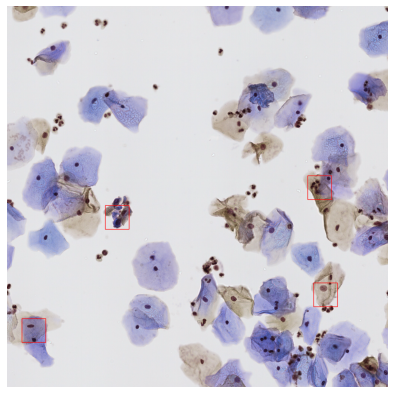

In [28]:
outputs = multi_out
# maxi = torch.max(torch.sigmoid(outputs.permute(0,2,3,1)[IMAGE_NUM,:,:,0])).cpu()
maxi = torch.max((outputs.permute(0,2,3,1)[IMAGE_NUM,:,:,0])).cpu()
print(maxi)
row, col = ((outputs.permute(0,2,3,1)[IMAGE_NUM,:,:,0]) > 0.5).cpu().detach().nonzero(as_tuple=True)
bboxes = []

# for x, y in zip(row, col) :
for x, y in zip(col, row) :
    xmin = int(x) * stride - (kernel_size-stride)/2
    xmax = xmin + kernel_size
    ymin = int(y) * stride - (kernel_size-stride)/2
    ymax = ymin + kernel_size
    bboxes.append([xmin, ymin, xmax, ymax])
print(len(bboxes))
visualize(images[IMAGE_NUM].permute(1,2,0).cpu().detach().numpy(), bboxes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 2048, 2048])
1
(2048, 2048, 3)


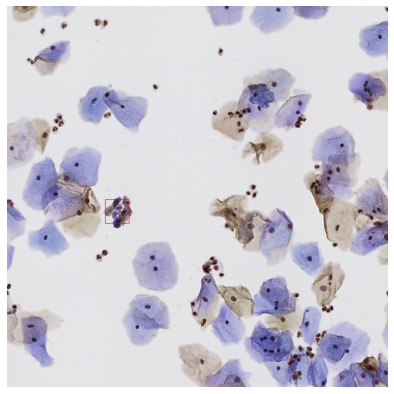

In [29]:
grid_size = 64
targets = targets[:,:,0].unsqueeze(dim=-1)
row, col = torch.where(targets.view(BATCH_SIZE,grid_size,grid_size)[IMAGE_NUM] == 1.)
bboxes = []

kernel_size = KERNEL_SIZE
stride = STRIDE
print(images.shape)
for x, y in zip(col, row) :
    xmin = int(x) * stride - (kernel_size-stride)/2
    xmax = xmin + kernel_size
    ymin = int(y) * stride - (kernel_size-stride)/2
    ymax = ymin + kernel_size
    bboxes.append([xmin, ymin, xmax, ymax])
print(len(bboxes))
visualize(images[IMAGE_NUM].permute(1,2,0).cpu().detach().numpy(), bboxes)

[[1.312e+03 1.700e+02 2.300e+02 2.550e+02 1.000e+00]]
(2048, 2048, 3)


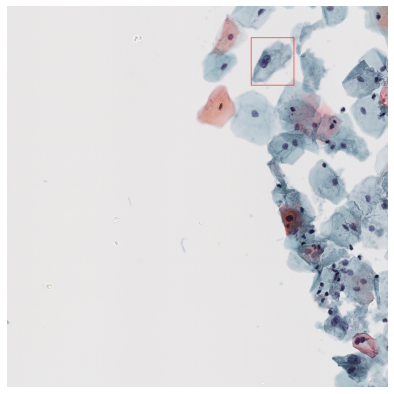

In [129]:
img_path = path[IMAGE_NUM]
abs_path = '/home/Dataset/scl/'

train_image = cv2.imread(abs_path + img_path)
train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
boxes = get_data(img_path)['boxes']
print(boxes)
boxes[:,2] = boxes[:,0] + boxes[:,2]
boxes[:,3] = boxes[:,1] + boxes[:,3]

visualize(train_image, boxes[:,:4])